In [1]:
import os

local_path = os.getcwd()
# 设置工作目录为项目的主目录
os.chdir("../../")  # 使用相对路径将工作目录切换到 project 文件夹
print("Current working directory:", os.getcwd())

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from models import modelset
from train.train import train_FBM
from utils import *

Current working directory: /home/yixiong_ren/work/FBM


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
set_seed(42)

Using device: cuda


In [3]:
train_loader, test_loader = load_small_MNIST()
data_iter = iter(train_loader)
images, labels = next(data_iter)
batch, channel, large, _ = images.shape


def get_accuracy(d_f):
    # 定义超参数
    input_size = channel * large**2 # MNIST图像大小是28x28
    hidden_dim =1000
    num_classes = 10      # MNIST有10个类别
    learning_rate = 0.01
    lam = 0.01
    d_f = 0.4
    num_epochs = 20
    batch_size = 64

    model = train_FBM(input_size = input_size, 
                    output_size = hidden_dim, 
                    lam = lam, 
                    d_f = d_f, 
                    learning_rate = learning_rate, 
                    train_loader = train_loader, 
                    num_epochs = num_epochs, 
                    device = device)

    train_loader1 = deal_dataloader(train_loader, model, device)



    # 定义损失函数和优化器
    model2 = modelset.MLP(hidden_dim, num_classes).to(device)
    criterion2 = nn.CrossEntropyLoss()  # 使用交叉熵损失
    optimizer = optim.Adam(model2.parameters(), lr=learning_rate)  # 使用随机梯度下降优化器

    model2.train()
    # 训练模型
    epochs = 30
    for epoch in range(epochs):
        for images, labels in train_loader1:
            # 将图像展平为一维向量，并将标签进行 one-hot 编码
            images = images.to(device)
            labels_one_hot = F.one_hot(labels, num_classes=num_classes).float().to(device)  # 将标签转换为 one-hot 编码

            # 前向传播
            outputs = model2(images)

            # 计算损失
            loss = criterion2(outputs, labels_one_hot)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


    # 设置模型为评估模式
    model.eval()
    model2.eval()

    # 准确率计数
    correct = 0
    total = 0

    # 禁用梯度计算，加速测试过程
    with torch.no_grad():
        for images, labels in test_loader:
            # 将数据加载到 GPU
            images = images.view(-1, input_size).to(device)
            labels = labels.to(device)

            # 前向传播
            outputs = model(images)
            outputs = model2(outputs)
            
            # 获取预测结果
            _, predicted = torch.max(outputs, 1)
            
            # 更新计数
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 计算准确率
    accuracy = 100 * correct / total
    #print(f'Accuracy on the test dataset: {accuracy:.2f}%')
    return accuracy

Images batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Sample labels: tensor([0, 4, 7, 8, 3, 7, 5, 1, 5, 3, 4, 6, 3, 0, 7, 5, 8, 0, 3, 0, 6, 6, 0, 2,
        6, 4, 4, 1, 9, 7, 0, 0, 0, 4, 6, 2, 8, 3, 4, 4, 0, 6, 7, 3, 1, 7, 3, 6,
        2, 2, 2, 2, 3, 3, 9, 5, 3, 3, 8, 1, 5, 4, 5, 2])


Epoch [1/20], Loss: 0.1454
Epoch [2/20], Loss: 0.1462
Epoch [3/20], Loss: 0.1388
Epoch [4/20], Loss: 0.1272
Epoch [5/20], Loss: 0.1135
Epoch [6/20], Loss: 0.1427
Epoch [7/20], Loss: 0.1381
Epoch [8/20], Loss: 0.1238
Epoch [9/20], Loss: 0.1065
Epoch [10/20], Loss: 0.1326
Epoch [11/20], Loss: 0.1331
Epoch [12/20], Loss: 0.1262
Epoch [13/20], Loss: 0.1116
Epoch [14/20], Loss: 0.1305
Epoch [15/20], Loss: 0.1255
Epoch [16/20], Loss: 0.1280
Epoch [17/20], Loss: 0.1365
Epoch [18/20], Loss: 0.1191
Epoch [19/20], Loss: 0.1167
Epoch [20/20], Loss: 0.0981
Processed data shape: torch.Size([1000, 1000])
Epoch [1/20], Loss: 0.1515
Epoch [2/20], Loss: 0.1377
Epoch [3/20], Loss: 0.1305
Epoch [4/20], Loss: 0.1322
Epoch [5/20], Loss: 0.1415
Epoch [6/20], Loss: 0.1315
Epoch [7/20], Loss: 0.1240
Epoch [8/20], Loss: 0.1285
Epoch [9/20], Loss: 0.1320
Epoch [10/20], Loss: 0.1242
Epoch [11/20], Loss: 0.1157
Epoch [12/20], Loss: 0.1386
Epoch [13/20], Loss: 0.1057
Epoch [14/20], Loss: 0.1090
Epoch [15/20], Loss

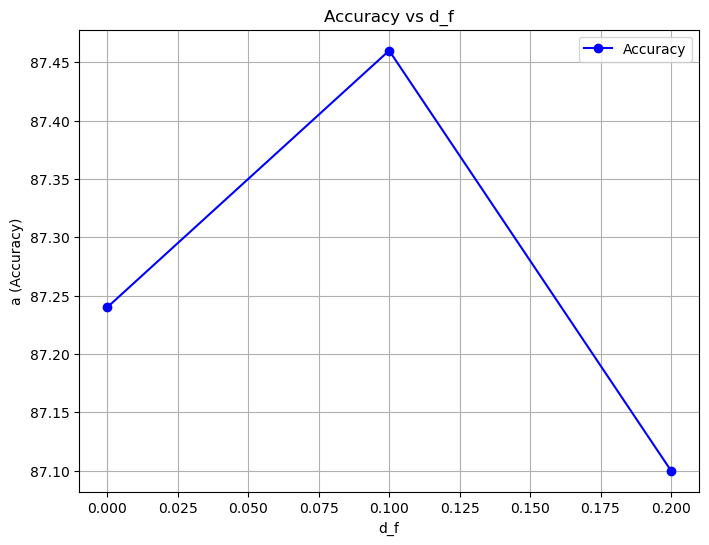

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 d_f 是在一定范围内变化的
d_f_values = [0.1 * i for i in range(3)]  # 生成 0 到 5 的 d_f 值
a_values = [get_accuracy(d_f) for d_f in d_f_values]  # 计算对应的 a 值

# 绘制 a 随 d_f 变化的曲线
plt.figure(figsize=(8, 6))
plt.plot(d_f_values, a_values, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('d_f')
plt.ylabel('a (Accuracy)')
plt.title('Accuracy vs d_f')
plt.legend()
plt.grid(True)

# 保存图像
plt.savefig(os.path.join(local_path, "accuracy_vs_d_f.png"))

# 保存数据到 CSV 文件
data = {'d_f': d_f_values, 'a': a_values}
df = pd.DataFrame(data)
df.to_csv(os.path.join(local_path, "accuracy_vs_d_f.csv"), index=False)

# 显示图像
plt.show()
